In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
import statistics

In [2]:

num_gpu = []
num_gpu_avg = []
num_client = []
num_client_avg = []
avg_detect_time = []
avg_detect_time_avg = []

In [3]:
filename = 'data_points.csv'
df = pd.read_csv(filename)
print(df.head())

   Num GPU  Num Client       Operation Name           Service  Duration
0        7          10  frame 360 detection          pyClient    188758
1        7          10               detect          pyServer     62606
2        7          10  frame 180 detection          pyClient    224245
3        7          10    get_detector_port  pyServer-ingress        66
4        7          10           request_id          pyClient  27792290


In [4]:
dict_gpu_client_time = {} # {(gpu, client): {time: time, num: num}}
trim_threshold = float('inf')
for index, row in df.iterrows():
    if row['Duration']/1000 < trim_threshold and row['Operation Name']=="detect":
        num_gpu.append(row['Num GPU'])
        num_client.append(row['Num Client'])
        avg_detect_time.append(row['Duration']/1000)
        dict_gpu_client_time[(row['Num GPU'], row['Num Client'])] = {
            'time': 0,
            'num': 0
        }
        dict_gpu_client_time[(row['Num GPU'], row['Num Client'])]['time'] += row['Duration']/1000
        dict_gpu_client_time[(row['Num GPU'], row['Num Client'])]['num'] += 1

In [5]:
for tuple_gpu_client, dict_time_num in dict_gpu_client_time.items():
    num_gpu_avg.append(tuple_gpu_client[0])
    num_client_avg.append(tuple_gpu_client[1])
    avg_detect_time_avg.append(dict_time_num['time']/dict_time_num['num'])

print(len(num_gpu), len(num_client), len(avg_detect_time), len(num_gpu_avg), len(num_client_avg), len(avg_detect_time_avg))

2984 2984 2984 20 20 20


/tmp/ipykernel_3380144/2100504363.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


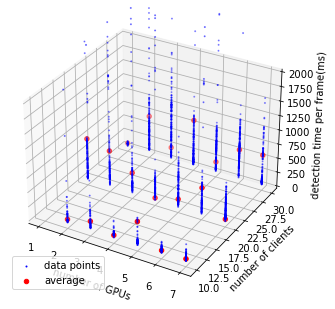

In [6]:

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num_gpu, num_client, avg_detect_time, c='b', s=1, label='data points')
ax.scatter(num_gpu_avg, num_client_avg, avg_detect_time_avg, c='r', s=20, label='average')
ax.legend(loc='best')
ax.set_zlabel('detection time per frame(ms)')
ax.set_xlabel('number of GPUs')
ax.set_ylabel('number of clients')
ax.set_zlim(0.0, 2000.0)
plt.show()

In [7]:
# fitting
a = 0
A = np.ones((len(avg_detect_time),3))
for i in range(0, len(avg_detect_time)):
    A[i, 0] = num_gpu[a]
    A[i, 1] = num_client[a]
    a += 1

b = np.zeros((len(avg_detect_time), 1))
a = 0
for i in range(0, len(avg_detect_time)):
    b[i, 0] = avg_detect_time[a]
    a += 1

A_T = A.T
A1 = np.dot(A_T,A)
A2 = np.linalg.inv(A1)
A3 = np.dot(A2,A_T)
X= np.dot(A3, b)
print('palne fitting result：z = %.3f * x + %.3f * y + %.3f'%(X[0,0],X[1,0],X[2,0]))
R=0
num_records = 0
for i in range(0,len(avg_detect_time)):
    R=R+(X[0, 0] * num_gpu[i] + X[1, 0] * num_client[i] + X[2, 0] - avg_detect_time[i])**2
    num_records += 1
R = R / num_records
print ('variance is: %.*f'%(3,R))

palne fitting result：z = -42.222 * x + 11.209 * y + 378.834
variance is: 416281.443


/tmp/ipykernel_3380144/2851072472.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


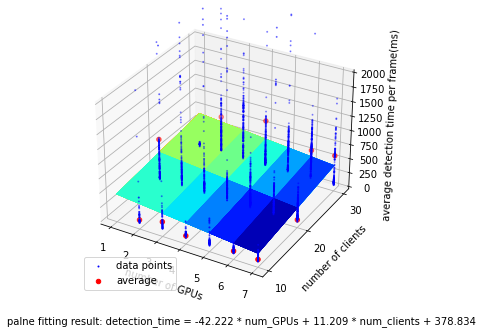

In [8]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num_gpu, num_client, avg_detect_time, c='b', s=1, label='data points')
ax.scatter(num_gpu_avg, num_client_avg, avg_detect_time_avg, c='r', label='average')
x_p, y_p = np.meshgrid(num_gpu[0:len(num_gpu):100], num_client[0:len(num_client):100])
z_p = X[0, 0] * x_p + X[1, 0] * y_p + X[2, 0]
ax.plot_surface(x_p, y_p, z_p, cmap=cm.jet, rstride=1, cstride=1)
ax.legend(loc='best')
ax.set_zlabel('average detection time per frame(ms)')
ax.set_xlabel('number of GPUs')
ax.set_ylabel('number of clients')
ax.set_title('')
ax.set_zlim(0.0, 2000.0)
ax.set_yticks([10,20,30])
ax.text2D(-0.25, -0.1, 'palne fitting result: detection_time = %.3f * num_GPUs + %.3f * num_clients + %.3f'%(X[0,0],X[1,0],X[2,0]), transform=ax.transAxes)
plt.show()

In [9]:
# regression
from sklearn.linear_model import LinearRegression
gpu_client = [[num_gpu[i], num_client[i]] for i in range(len(num_gpu))]
model = LinearRegression()
model.fit(gpu_client, avg_detect_time)
coe = model.coef_
intercept = model.intercept_
equation =  "detection time = " + str(round(coe[0],2)) + "*num_GPUs + " + str(round(coe[1],2)) + "*num_clients +" + str(round(intercept,2))
print(equation)

detection time = -42.22*num_GPUs + 11.21*num_clients +378.83


/tmp/ipykernel_3380144/95262497.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


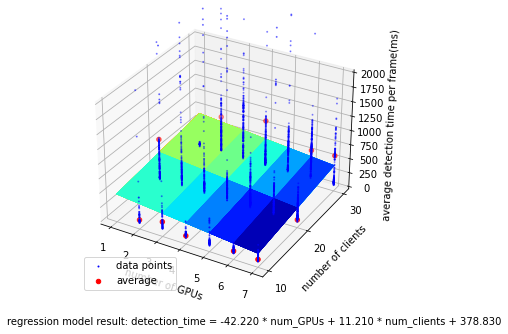

In [10]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num_gpu, num_client, avg_detect_time, c='b', s=1, label='data points')
ax.scatter(num_gpu_avg, num_client_avg, avg_detect_time_avg, c='r', s=20, label='average')
x_p, y_p = np.meshgrid(num_gpu[0:len(num_gpu):100], num_client[0:len(num_client):100])
z_p = round(coe[0],2) * x_p + round(coe[1],2) * y_p + round(intercept,2)
ax.plot_surface(x_p, y_p, z_p, cmap=cm.jet, rstride=1, cstride=1)
ax.legend(loc='best')
ax.set_zlabel('average detection time per frame(ms)')
ax.set_xlabel('number of GPUs')
ax.set_ylabel('number of clients')
ax.set_title('')
ax.set_zlim(0.0, 2000.0)
ax.set_yticks([10,20,30])
ax.text2D(-0.25, -0.1, 'regression model result: detection_time = %.3f * num_GPUs + %.3f * num_clients + %.3f'%(round(coe[0],2),round(coe[1],2),round(intercept,2)), transform=ax.transAxes)
plt.show()

In [11]:
# regression (inverse GPU)
from sklearn.linear_model import LinearRegression
inverse_gpu_client = [[1.0 / num_gpu[i], num_client[i]] for i in range(len(num_gpu))]
inverse_model = LinearRegression()
inverse_model.fit(inverse_gpu_client, avg_detect_time)
coe = inverse_model.coef_
intercept = inverse_model.intercept_
equation =  "detection time = " + str(round(coe[0],2)) + "/num_GPUs + " + str(round(coe[1],2)) + "*num_clients +" + str(round(intercept,2))
print(equation)

detection time = 147.68/num_GPUs + 11.53*num_clients +143.21


/tmp/ipykernel_3380144/355670252.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


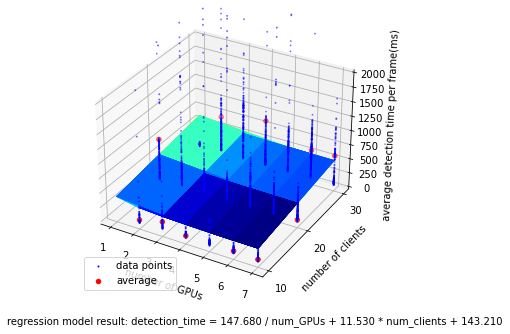

In [12]:


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(num_gpu, num_client, avg_detect_time, c='b', s=1, label='data points')
ax.scatter(num_gpu_avg, num_client_avg, avg_detect_time_avg, c='r', label='average')
x_p, y_p = np.meshgrid(num_gpu[0:len(num_gpu):100], num_client[0:len(num_client):100])
z_p = round(coe[0],2) * 1.0/x_p + round(coe[1],2) * y_p + round(intercept,2)
ax.plot_surface(x_p, y_p, z_p, cmap=cm.jet, rstride=1, cstride=1)
ax.legend(loc='best')
ax.set_zlabel('average detection time per frame(ms)')
ax.set_xlabel('number of GPUs')
ax.set_ylabel('number of clients')
ax.set_zlim(0.0, 2000.0)
ax.set_yticks([10,20,30])
ax.set_title('')
ax.text2D(-0.25, -0.1, 'regression model result: detection_time = %.3f / num_GPUs + %.3f * num_clients + %.3f'%(round(coe[0],2),round(coe[1],2),round(intercept,2)), transform=ax.transAxes)
plt.show()

In [13]:
# calculate variation
R=0
num_records = 0
for i in range(0,len(avg_detect_time)):
    R=R+( coe[0] * 1 / num_gpu[i] + coe[1] * num_client[i] + intercept - avg_detect_time[i])**2
    num_records += 1
R = R / num_records
print ('variance is: %.*f'%(3,R))

variance is: 421472.962


Could you plot only the red points, and plot them in a 2D setting: so 3 curves, corresponding to demands 10, 20, 30, and then for each curve print out the red dots in different shapes connected by a dotted line, and then the regression result as a solid line, or something like that.

In [14]:
num_gpu_avg_detection_time_10_client = {} #{num_gpu: [records]}
num_gpu_avg_detection_time_20_client = {} #{num_gpu: [records]}
num_gpu_avg_detection_time_30_client = {} #{num_gpu: [records]}

trim_threshold = float('inf') #2000.0

for i in range(1,8):
    num_gpu_avg_detection_time_10_client[i] = []
    num_gpu_avg_detection_time_20_client[i] = []
    num_gpu_avg_detection_time_30_client[i] = []

for index, row in df.iterrows():
    if row['Duration']/1000 < trim_threshold and row['Operation Name']=="detect":
        if row['Num Client'] == 10:
            if row['Num GPU'] in num_gpu_avg_detection_time_10_client:
                num_gpu_avg_detection_time_10_client[row['Num GPU']].append(row['Duration']/1000)
            else:
                num_gpu_avg_detection_time_10_client[row['Num GPU']] = [row['Duration']/1000]
        if row['Num Client'] == 20:
            if row['Num GPU'] in num_gpu_avg_detection_time_20_client:
                num_gpu_avg_detection_time_20_client[row['Num GPU']].append(row['Duration']/1000)
            else:
                num_gpu_avg_detection_time_20_client[row['Num GPU']] = [row['Duration']/1000]
        if row['Num Client'] == 30:
            if row['Num GPU'] in num_gpu_avg_detection_time_30_client:
                num_gpu_avg_detection_time_30_client[row['Num GPU']].append(row['Duration']/1000)
            else:
                num_gpu_avg_detection_time_30_client[row['Num GPU']] = [row['Duration']/1000]

for i in range(1,8):
    if len(num_gpu_avg_detection_time_10_client[i]) == 0:
        num_gpu_avg_detection_time_10_client[i] = [0]
    if len(num_gpu_avg_detection_time_20_client[i]) == 0:
        num_gpu_avg_detection_time_20_client[i] = [0]
    if len(num_gpu_avg_detection_time_30_client[i]) == 0:
        num_gpu_avg_detection_time_30_client[i] = [0]

# for i in range(1,8):
#     num_gpu_avg_detection_time_10_client[i]['mean'] = num_gpu_avg_detection_time_10_client[i]['time'] / num_gpu_avg_detection_time_10_client[i]['num_record'] 
#     num_gpu_avg_detection_time_20_client[i]['time'] = num_gpu_avg_detection_time_20_client[i]['time'] / num_gpu_avg_detection_time_20_client[i]['num_record'] 
#     num_gpu_avg_detection_time_30_client[i]['time'] = num_gpu_avg_detection_time_30_client[i]['time'] / num_gpu_avg_detection_time_30_client[i]['num_record'] 

In [15]:
x = np.arange(1, 8)
y_10_clients = []
y_20_clients = []
y_30_clients = []

for i in x:
    y_10_clients.append(statistics.mean(num_gpu_avg_detection_time_10_client[i])) 
    y_20_clients.append(statistics.mean(num_gpu_avg_detection_time_20_client[i]))  
    y_30_clients.append(statistics.mean(num_gpu_avg_detection_time_30_client[i]))  
y_10_clients = np.array(y_10_clients)
y_20_clients = np.array(y_20_clients)
y_30_clients = np.array(y_30_clients)

regression_y_10_clients = coe[0] * 1./x + 10 * coe[1] + intercept
regression_y_20_clients = coe[0] * 1./x + 20 * coe[1] + intercept
regression_y_30_clients = coe[0] * 1./x + 30 * coe[1] + intercept


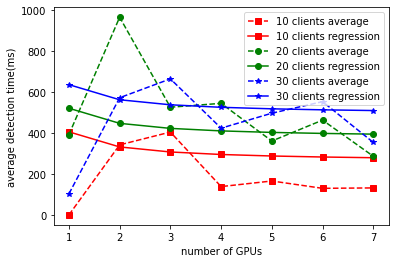

In [16]:
fig = plt.figure()
plt.plot(x, y_10_clients, 's--', color = 'r', label="10 clients average")
plt.plot(x, regression_y_10_clients, 's-', color = 'r', label="10 clients regression")
plt.plot(x, y_20_clients, 'o--', color = 'g', label="20 clients average")
plt.plot(x, regression_y_20_clients, 'o-', color = 'g', label="20 clients regression")
plt.plot(x, y_30_clients, '*--', color = 'b', label="30 clients average")
plt.plot(x, regression_y_30_clients, '*-', color = 'b', label="30 clients regression")
plt.xlabel("number of GPUs")
plt.ylabel("average detection time(ms)")
plt.legend(loc = "best")
plt.show()